In [ ]:
# Cell 1 — check versions
import tensorflow as tf, tensorflow_datasets as tfds
print("TF", tf.__version__, "TFDS", tfds.__version__)

TF 2.19.0 TFDS 4.9.9


In [ ]:
import os
from your_module import gr_fn, iface 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.GSB3XP_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.GSB3XP_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
Loaded EMNIST.
image shape: (28, 28, 1) label: 5


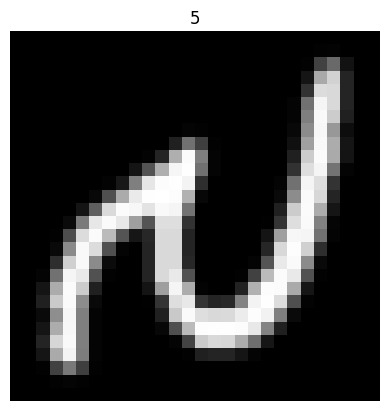

In [ ]:
# Cell 2 — download and load EMNIST (this may take a minute)
import tensorflow as tf, tensorflow_datasets as tfds
ds_train = tfds.load("emnist/byclass", split="train", as_supervised=True)
ds_test  = tfds.load("emnist/byclass", split="test",  as_supervised=True)
print("Loaded EMNIST.")

# show one example
for img, lbl in ds_train.take(1):
    print("image shape:", img.shape, "label:", int(lbl.numpy()))
    import matplotlib.pyplot as plt
    plt.imshow(tf.squeeze(img), cmap='gray'); plt.title(int(lbl.numpy())); plt.axis('off')

In [ ]:
# Cell 3 — orientation fix + tf.data pipelines
import numpy as np, tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
BATCH = 128

# EMNIST images from TFDS are rotated/flipped; fix using numpy op via tf.numpy_function
def fix_emnist_numpy(img, label):
    import numpy as np
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)
    img = np.rot90(img)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

train_ds = ds_train.map(tf_fix, num_parallel_calls=AUTOTUNE).shuffle(20000).batch(BATCH).prefetch(AUTOTUNE)
test_ds  = ds_test.map(tf_fix, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)

# small validation split from train
VAL_STEPS = 200
val_ds = train_ds.take(VAL_STEPS)
train_ds = train_ds.skip(VAL_STEPS)

print("Pipelines ready. Example batch shapes:")
for x,y in train_ds.take(1):
    print(x.shape, y.shape)

Pipelines ready. Example batch shapes:
(128, 28, 28, 1) (128,)


In [ ]:
# Cell 4 — model
from tensorflow.keras import layers, models
def make_model(input_shape=(28,28,1), num_classes=62):
    inp = layers.Input(input_shape)
    x = layers.Conv2D(32,3,padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inp, out)

model = make_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,670 (1.54 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Cell 5 — train (runs ~10–15 mins on Colab GPU if available; adjust epochs)
EPOCHS = 12
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint_path = "/content/best_emnist.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7599 - loss: 0.8052
Epoch 1: val_loss improved from inf to 0.41913, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1561s 294ms/step - accuracy: 0.7599 - loss: 0.8052 - val_accuracy: 0.8480 - val_loss: 0.4191 - learning_rate: 0.0010
Epoch 2/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8426 - loss: 0.4514
Epoch 2: val_loss improved from 0.41913 to 0.38150, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1524s 287ms/step - accuracy: 0.8426 - loss: 0.4514 - val_accuracy: 0.8614 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 3/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8535 - loss: 0.4130
Epoch 3: val_loss improved from 0.38150 to 0.35005, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1574s 286ms/step - accuracy: 0.8535 - loss: 0.4130 - val_accuracy: 0.8729 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 4/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8597 - loss: 0.3921
Epoch 4: val_loss did not improve from 0.35005
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1528s 287ms/step - accuracy: 0.8597 - loss: 0.3921 - val_accuracy: 0.8695 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 5/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8631 - loss: 0.3777
Epoch 5: val_loss improved from 0.35005 to 0.34879, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1522s 287ms/step - accuracy: 0.8631 - loss: 0.3777 - val_accuracy: 0.8713 - val_loss: 0.3488 - learning_rate: 0.0010
Epoch 6/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8661 - loss: 0.3653
Epoch 6: val_loss improved from 0.34879 to 0.33786, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1580s 286ms/step - accuracy: 0.8661 - loss: 0.3653 - val_accuracy: 0.8719 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 7/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8680 - loss: 0.3579
Epoch 7: val_loss did not improve from 0.33786
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1546s 292ms/step - accuracy: 0.8680 - loss: 0.3579 - val_accuracy: 0.8732 - val_loss: 0.3419 - learning_rate: 0.0010
Epoch 8/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8708 - loss: 0.3488
Epoch 8: val_loss improved from 0.33786 to 0.33146, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1568s 296ms/step - accuracy: 0.8708 - loss: 0.3488 - val_accuracy: 0.8767 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 9/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8716 - loss: 0.3439
Epoch 9: val_loss improved from 0.33146 to 0.32766, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1580s 298ms/step - accuracy: 0.8716 - loss: 0.3439 - val_accuracy: 0.8789 - val_loss: 0.3277 - learning_rate: 0.0010
Epoch 10/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8736 - loss: 0.3388
Epoch 10: val_loss did not improve from 0.32766
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1527s 288ms/step - accuracy: 0.8736 - loss: 0.3388 - val_accuracy: 0.8780 - val_loss: 0.3311 - learning_rate: 0.0010
Epoch 11/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8747 - loss: 0.3335
Epoch 11: val_loss improved from 0.32766 to 0.32363, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1530s 288ms/step - accuracy: 0.8747 - loss: 0.3335 - val_accuracy: 0.8780 - val_loss: 0.3236 - learning_rate: 0.0010
Epoch 12/12
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8753 - loss: 0.3313
Epoch 12: val_loss improved from 0.32363 to 0.31879, saving model to /content/best_emnist.h5


5253/5253 ━━━━━━━━━━━━━━━━━━━━ 1562s 295ms/step - accuracy: 0.8753 - loss: 0.3313 - val_accuracy: 0.8819 - val_loss: 0.3188 - learning_rate: 0.0010


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/EMNIST_Project

In [ ]:
model.save("/content/drive/MyDrive/EMNIST_Project/final_emnist.keras")
print("✅ Model saved successfully to Google Drive!")

✅ Model saved successfully to Google Drive!


In [ ]:
!ls -lh /content/drive/MyDrive/EMNIST_Project

total 4.7M
-rw------- 1 root root 4.7M Oct  7 18:23 final_emnist.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lh /content/drive/MyDrive/EMNIST_Project

total 4.9M
-rw------- 1 root root 4.7M Oct  7 18:23  final_emnist.keras
-rw------- 1 root root 119K Oct  8 05:55 'first file.ipynb'


In [ ]:
from tensorflow import keras

model_path = "/content/drive/MyDrive/EMNIST_Project/final_emnist.keras"
model = keras.models.load_model(model_path)
print("✅ Model loaded from:", model_path)
model.summary()

✅ Model loaded from: /content/drive/MyDrive/EMNIST_Project/final_emnist.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 808,894 (3.09 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 404,224 (1.54 MB)

909/909 ━━━━━━━━━━━━━━━━━━━━ 95s 105ms/step - accuracy: 0.8759 - loss: 0.3388

✅ Fixed Orientation Test Accuracy: 87.51%   (loss: 0.3410)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


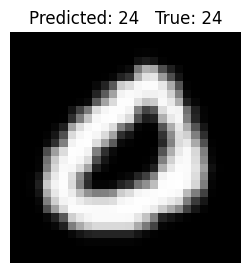

In [ ]:
# --- Corrected Preprocessing (matches your training orientation) ---
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def fix_emnist_numpy(img, label):
    import numpy as np
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)        # mirror horizontally
    img = np.rot90(img)         # rotate 90 degrees counter-clockwise
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

# Load and preprocess test data using the fix
BATCH = 128
ds_test_fixed = tfds.load("emnist/byclass", split="test", as_supervised=True)
ds_test_fixed = ds_test_fixed.map(tf_fix, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Evaluate again
test_loss, test_acc = model.evaluate(ds_test_fixed)
print(f"\n✅ Fixed Orientation Test Accuracy: {test_acc*100:.2f}%   (loss: {test_loss:.4f})")

# Show one sample visually
for img_batch, lbl_batch in ds_test_fixed.take(1):
    preds = model.predict(img_batch)
    pred0 = int(np.argmax(preds[0]))
    true0 = int(lbl_batch.numpy()[0])
    plt.figure(figsize=(3,3))
    plt.imshow(np.squeeze(img_batch[0]), cmap='gray')
    plt.title(f"Predicted: {pred0}   True: {true0}")
    plt.axis('off')
    plt.show()
    break

909/909 ━━━━━━━━━━━━━━━━━━━━ 88s 97ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


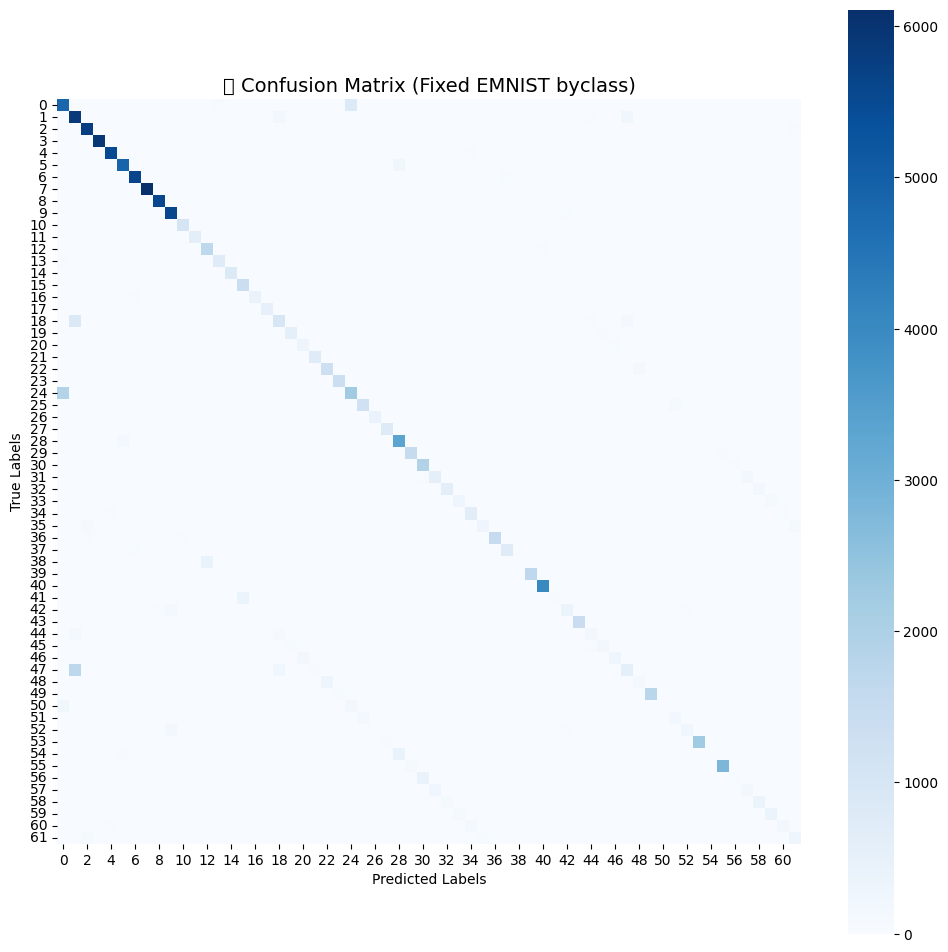


📊 Classification Report (first 20 classes):
              precision    recall  f1-score   support

           0       0.69      0.84      0.75      5778
           1       0.68      0.93      0.79      6330
           2       0.96      0.98      0.97      5869
           3       1.00      0.99      1.00      5969
           4       0.98      0.98      0.98      5619
           5       0.96      0.94      0.95      5190
           6       0.98      0.99      0.98      5705
           7       0.99      1.00      0.99      6139
           8       0.98      0.99      0.99      5633
           9       0.93      0.98      0.96      5686
          10       0.95      0.99      0.97      1062
          11       0.94      0.96      0.95       648
          12       0.78      0.96      0.86      1739
          13       0.91      0.92      0.92       779
          14       0.96      0.98      0.97       851
          15       0.78      0.97      0.87      1440
          16       0.92      0.93   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Use the fixed EMNIST test dataset
y_true = np.concatenate([y for x, y in ds_test_fixed], axis=0)
y_pred = np.argmax(model.predict(ds_test_fixed), axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(cm, cmap="Blues", cbar=True, square=True)
plt.title("✅ Confusion Matrix (Fixed EMNIST byclass)", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# --- Classification Report ---
print("\n📊 Classification Report (first 20 classes):")
print(classification_report(y_true, y_pred, labels=range(20)))

# --- Accuracy check ---
correct_preds = np.sum(y_true == y_pred)
accuracy = correct_preds / len(y_true)
print(f"\n✅ Recomputed Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
model.save("/content/drive/MyDrive/EMNIST_Project/final_emnist_fixed.keras")

In [ ]:
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')

model = keras.models.load_model("/content/drive/MyDrive/EMNIST_Project/final_emnist_fixed.keras")
print("✅ Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# ===== Fine-tune EMNIST model (one cell to run) =====
import os, pickle
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt

# 0) Mount Drive (skip if already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 1) Load saved model (change path if needed)
MODEL_DRIVE_PATH = "/content/drive/MyDrive/EMNIST_Project/final_emnist_fixed.keras"
print("Loading model from:", MODEL_DRIVE_PATH)
model = keras.models.load_model(MODEL_DRIVE_PATH)
print("Model loaded ✅")
model.summary()

# 2) Preprocessing functions (same orientation fix you used before)
import numpy as np

def fix_emnist_numpy(img, label):
    # numpy-based orientation fix (same as training)
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)   # mirror horizontally
    img = np.rot90(img)    # rotate 90° CCW
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)   # (28,28,1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

# 3) Data pipelines
BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE

# Training augmentation pipeline (small, safe augmentations)
def augment(img, label):
    # img is float32 in [0,1], shape (28,28,1)
    img = tf.image.random_flip_left_right(img)          # small random mirror
    img = tf.image.random_brightness(img, 0.08)         # small brightness change
    img = tf.image.random_contrast(img, 0.9, 1.1)       # small contrast
    # random slight rotation using tf.image.rot90 is too coarse; skip heavy transforms for 28x28
    return img, label

print("Building dataset pipelines (this will download TFDS if not present) ...")
train_ds = tfds.load("emnist/byclass", split="train", as_supervised=True)
# apply orientation fix, then augmentation, shuffle, batch
train_ds = train_ds.map(tf_fix, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(20000).batch(BATCH).prefetch(AUTOTUNE)

val_ds = tfds.load("emnist/byclass", split="test", as_supervised=True)
val_ds = val_ds.map(tf_fix, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)

# 4) Fine-tune strategy: lower LR, optional unfreeze
# If your model was fully trainable already, keep layers trainable; otherwise unfreeze last conv blocks.
# Here we keep all layers trainable (safe), but set small LR.
for layer in model.layers:
    layer.trainable = True

# 5) Compile with low LR
initial_lr = 1e-4
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# 6) Callbacks: checkpoint to Drive, early stop, reduce LR on plateau
out_dir = "/content/drive/MyDrive/EMNIST_Project"
os.makedirs(out_dir, exist_ok=True)
ckpt_path = os.path.join(out_dir, "ckpt_emnist_finetune_epoch{epoch:02d}_val{val_accuracy:.4f}.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, mode="max", restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

# 7) Train: keep epochs small to start; increase later if needed
EPOCHS = 4   # start small; increase to 8-12 if you want more fine-tuning
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# 8) Save final fine-tuned model and training history
final_model_path = os.path.join(out_dir, "final_emnist_finetuned.keras")
model.save(final_model_path)
print("Saved fine-tuned model to:", final_model_path)

history_path = os.path.join(out_dir, "history_finetune.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)
print("Saved history to:", history_path)

# 9) Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get("loss",[]), label="train_loss")
plt.plot(history.history.get("val_loss",[]), label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history.get("accuracy",[]), label="train_acc")
plt.plot(history.history.get("val_accuracy",[]), label="val_acc")
plt.legend(); plt.title("Accuracy")
plt.show()

# 10) Quick re-eval on fixed test set
test_loss, test_acc = model.evaluate(val_ds)
print(f"✅ Post-finetune test accuracy: {test_acc*100:.2f}%  loss: {test_loss:.4f}")

Mounted at /content/drive
Loading model from: /content/drive/MyDrive/EMNIST_Project/final_emnist_fixed.keras
Model loaded ✅


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,116 (4.63 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 808,446 (3.08 MB)

Building dataset pipelines (this will download TFDS if not present) ...
Epoch 1/4

Epoch 1: val_accuracy improved from -inf to 0.85416, saving model to /content/drive/MyDrive/EMNIST_Project/ckpt_emnist_finetune_epoch01_val0.8542.keras
5453/5453 - 1775s - 325ms/step - accuracy: 0.7400 - loss: 0.8941 - val_accuracy: 0.8542 - val_loss: 0.4037 - learning_rate: 1.0000e-04
Epoch 2/4

Epoch 2: val_accuracy improved from 0.85416 to 0.85576, saving model to /content/drive/MyDrive/EMNIST_Project/ckpt_emnist_finetune_epoch02_val0.8558.keras
5453/5453 - 1812s - 332ms/step - accuracy: 0.8126 - loss: 0.5617 - val_accuracy: 0.8558 - val_loss: 0.3968 - learning_rate: 1.0000e-04
Epoch 3/4

Epoch 3: val_accuracy improved from 0.85576 to 0.85705, saving model to /content/drive/MyDrive/EMNIST_Project/ckpt_emnist_finetune_epoch03_val0.8571.keras
5453/5453 - 1760s - 323ms/step - accuracy: 0.8261 - loss: 0.5112 - val_accuracy: 0.8571 - val_loss: 0.3909 - learning_rate: 1.0000e-04
Epoch 4/4


In [ ]:
# ✅ Save the final fine-tuned model safely
model.save("/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned.keras")
print("✅ Final fine-tuned model saved to Drive!")

✅ Final fine-tuned model saved to Drive!


In [ ]:
import pickle

with open("/content/drive/MyDrive/EMNIST_Project/history_finetune.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("📈 Training history saved to Drive.")

📈 Training history saved to Drive.


In [ ]:
!ls -lh /content/drive/MyDrive/EMNIST_Project

total 31M
-rw------- 1 root root 4.7M Oct  9 03:51  ckpt_emnist_finetune_epoch01_val0.8542.keras
-rw------- 1 root root 4.7M Oct  9 04:22  ckpt_emnist_finetune_epoch02_val0.8558.keras
-rw------- 1 root root 4.7M Oct  9 04:51  ckpt_emnist_finetune_epoch03_val0.8571.keras
-rw------- 1 root root 4.7M Oct  9 05:20  ckpt_emnist_finetune_epoch04_val0.8587.keras
-rw------- 1 root root 4.7M Oct  9 05:32  final_emnist_finetuned.keras
-rw------- 1 root root 1.6M Oct  8 06:51  final_emnist_fixed.keras
-rw------- 1 root root 4.7M Oct  7 18:23  final_emnist.keras
-rw------- 1 root root 306K Oct  9 05:22 'first file.ipynb'
-rw------- 1 root root  276 Oct  9 05:33  history_finetune.pkl


In [ ]:
# --- Resume session: Mount Drive and load fine-tuned model ---
from google.colab import drive
from tensorflow import keras
import pickle, os

# 1️⃣ Mount your Drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Define paths
MODEL_PATH = "/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned.keras"
HISTORY_PATH = "/content/drive/MyDrive/EMNIST_Project/history_finetune.pkl"

# 3️⃣ Load model
model = keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully from Drive!")

# 4️⃣ Print summary
model.summary()

# 5️⃣ Load training history if available
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, "rb") as f:
        history = pickle.load(f)
    print(f"📈 History loaded with keys: {list(history.keys())}")
else:
    print("⚠️ No previous history found.")

Mounted at /content/drive
✅ Model loaded successfully from Drive!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,116 (4.63 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 808,446 (3.08 MB)

📈 History loaded with keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

# Same preprocessing function as before
def fix_emnist_numpy(img, label):
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)
    img = np.rot90(img)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

# Load only test set
BATCH = 128
ds_test_fixed = tfds.load("emnist/byclass", split="test", as_supervised=True)
ds_test_fixed = ds_test_fixed.map(tf_fix, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Evaluate
test_loss, test_acc = model.evaluate(ds_test_fixed)
print(f"\n✅ Restored model test accuracy: {test_acc*100:.2f}% | loss: {test_loss:.4f}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.U6ODUF_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.U6ODUF_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
909/909 ━━━━━━━━━━━━━━━━━━━━ 85s 93ms/step - accuracy: 0.8588 - loss: 0.3860

✅ Restored model test accuracy: 85.87% | loss: 0.3868


In [ ]:
# -------------- Diagnostics: confusion matrix + per-class report --------------
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# dataset used for evaluation (same fix function you used before)
def fix_emnist_numpy(img, label):
    import numpy as np
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)
    img = np.rot90(img)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

ds_test = tfds.load("emnist/byclass", split="test", as_supervised=True)
ds_test = ds_test.map(tf_fix, num_parallel_calls=tf.data.AUTOTUNE).batch(128)

# gather preds & truths (may take time)
y_true = []
y_pred = []
for imgs, labels in ds_test:
    preds = model.predict(imgs)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)

# confusion + report
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

report = classification_report(y_true, y_pred, output_dict=True)
# print a readable top-20 summary
import pandas as pd
df = pd.DataFrame(report).T
print("Classification report (first 20 classes):")
print(df.iloc[:20][['precision','recall','f1-score','support']])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # if already mounted this will be fine

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os

# <-- EDIT this path if your file name or folder is different -->
model_path = "/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned.keras"

if not os.path.exists(model_path):
    print("Model file not found at:", model_path)
    print("List files in the folder:")
    display(os.listdir("/content/drive/MyDrive/EMNIST_Project"))
else:
    # load model (don't compile right away to avoid optimizer mismatch warnings)
    model = keras.models.load_model(model_path, compile=False)
    print("✅ Model loaded from:", model_path)
    model.summary()   # optional: show architecture

✅ Model loaded from: /content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,670 (1.54 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

Building fixed test dataset (this may download TFDS if not present)...
Running model predictions over the test set (may take several minutes)...
Confusion matrix shape: (62, 62)

Worst classes by recall (lowest first):


,precision,recall,f1-score,support
50,0.500000,0.002146,0.004274,466.0
54,1.000000,0.004577,0.009112,437.0
38,0.250000,0.011574,0.022124,432.0
56,0.666667,0.041494,0.078125,482.0
48,0.578947,0.047414,0.087649,464.0
41,0.684211,0.065000,0.118721,400.0
47,0.545648,0.202761,0.295657,2535.0
51,0.717557,0.255435,0.376754,368.0
57,0.565737,0.303419,0.394993,468.0
44,0.791045,0.372365,0.506369,427.0



Top 3 worst classes: [50, 54, 38]

Class 50 — 465 misclassified in test set. Showing up to 5 examples:


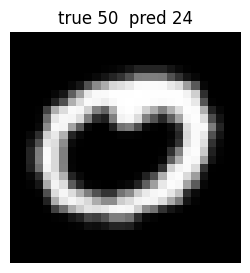

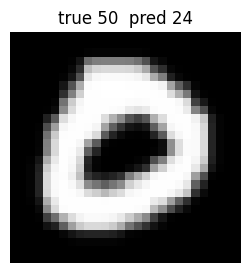

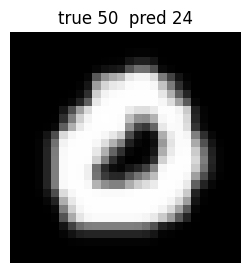

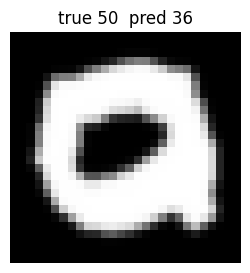

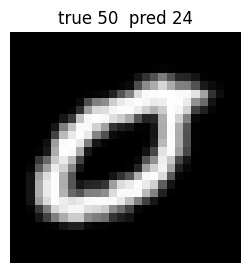


Class 54 — 435 misclassified in test set. Showing up to 5 examples:


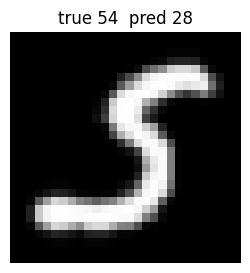

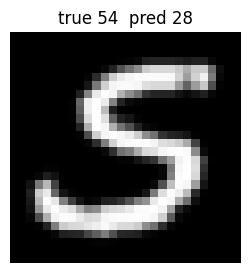

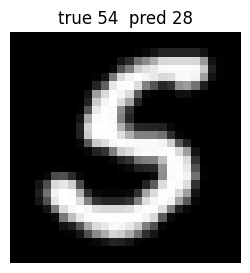

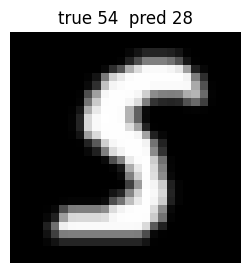

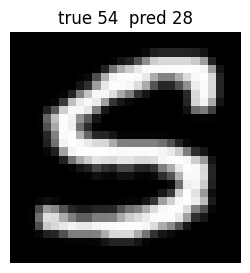


Class 38 — 427 misclassified in test set. Showing up to 5 examples:


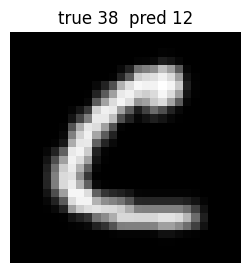

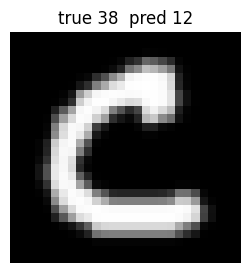

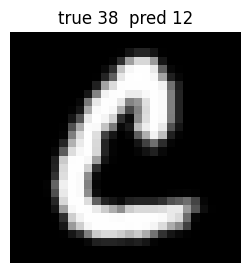

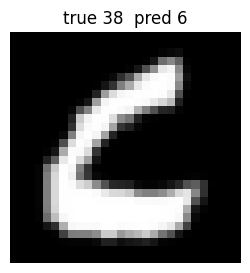

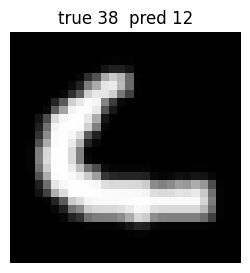

In [ ]:
# ================== INSPECT: worst classes + examples ==================
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import tensorflow_datasets as tfds, tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# --- orientation fix: use same fix you used during training ---
def fix_emnist_numpy(img, label):
    import numpy as np
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)        # mirror horizontally
    img = np.rot90(img)         # rotate 90 degrees counter-clockwise
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

BATCH = 128
print("Building fixed test dataset (this may download TFDS if not present)...")
ds_test_fixed = tfds.load("emnist/byclass", split="test", as_supervised=True)
ds_test_fixed = ds_test_fixed.map(tf_fix, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# compute preds and truths (this can take a few minutes)
y_true = []
y_pred = []
X_samples = []   # store a few images so we can show

print("Running model predictions over the test set (may take several minutes)...")
for imgs, labels in ds_test_fixed:
    preds = model.predict(imgs, verbose=0)   # requires model loaded
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    # store images (only first N)
    if len(X_samples) < 20000:
        X_samples.extend(imgs.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
X_samples = np.array(X_samples)

print("Confusion matrix shape:", confusion_matrix(y_true, y_pred).shape)
rep = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(rep).transpose()

# show worst classes by recall (lowest recall first)
label_rows = df[df.index.map(lambda x: str(x).isdigit())].sort_values('recall')
print("\nWorst classes by recall (lowest first):")
display(label_rows[['precision','recall','f1-score','support']].head(12))

# show misclassified examples for top 3 worst classes
worst = list(map(int, label_rows.index.astype(int)[:3]))
print("\nTop 3 worst classes:", worst)

for cls in worst:
    idxs = np.where((y_true==cls) & (y_pred!=cls))[0]
    print(f"\nClass {cls} — {len(idxs)} misclassified in test set. Showing up to 5 examples:")
    for i in idxs[:5]:
        plt.figure(figsize=(3,3))
        plt.imshow(np.squeeze(X_samples[i]), cmap='gray')
        plt.title(f"true {y_true[i]}  pred {y_pred[i]}")
        plt.axis('off')
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # if already mounted this will be fine

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os

# <-- EDIT this path if your file name or folder is different -->
model_path = "/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned.keras"

if not os.path.exists(model_path):
    print("Model file not found at:", model_path)
    print("List files in the folder:")
    display(os.listdir("/content/drive/MyDrive/EMNIST_Project"))
else:
    # load model (don't compile right away to avoid optimizer mismatch warnings)
    model = keras.models.load_model(model_path, compile=False)
    print("✅ Model loaded from:", model_path)
    model.summary()   # optional: show architecture

✅ Model loaded from: /content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,670 (1.54 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# --- orientation fix functions (must run before dataset mapping) ---
import numpy as np
import tensorflow as tf

def fix_emnist_numpy(img, label):
    # accepts numpy image shape (28,28,1) or (28,28)
    img = np.squeeze(img).astype(np.uint8)
    # EMNIST needs mirrored + rotated -> do flip left-right then rotate 90 deg ccw
    img = np.fliplr(img)
    img = np.rot90(img)          # rotate 90 degrees
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)   # (28,28,1)
    return img, label

def tf_fix(img, label):
    # use tf.numpy_function to run the numpy fix inside the TF pipeline
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

print("✅ tf_fix defined")

✅ tf_fix defined


In [ ]:
# --- Targeted fine-tune: oversample + augment worst classes ---
import tensorflow as tf, tensorflow_datasets as tfds, numpy as np, os
from tensorflow import keras

# --- Config (edit targets / paths if you want) ---
TARGET_CLASSES = [50, 54, 38]            # worst classes you found
BATCH = 128
EPOCHS = 4                                # start small
REPEAT_MINORITY = 3
SAVE_DIR = "/content/drive/MyDrive/EMNIST_Project"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- augmentation (uses tfa if available for rotation) ---
try:
    import tensorflow_addons as tfa
except Exception:
    tfa = None

def augment_with_tfa(img, lbl):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.12)
    img = tf.image.random_contrast(img, 0.85, 1.15)
    if tfa is not None:
        ang = tf.random.uniform([], -0.12, 0.12)
        img = tfa.image.rotate(img, ang, interpolation='BILINEAR')
    return img, lbl

def augment_no_tfa(img, lbl):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.12)
    img = tf.image.random_contrast(img, 0.85, 1.15)
    return img, lbl

augment_fn = augment_with_tfa if tfa is not None else augment_no_tfa

# --- load train dataset and apply orientation fix (tf_fix must be defined in session) ---
print("Building train dataset (this may download TFDS if needed)...")
ds_train = tfds.load("emnist/byclass", split="train", as_supervised=True)
ds_train = ds_train.map(tf_fix, num_parallel_calls=tf.data.AUTOTUNE)

# --- create minority dataset filtered for target classes, then augment & repeat ---
target_tensor = tf.constant(TARGET_CLASSES, dtype=tf.int64)
def is_target(img, lbl):
    return tf.reduce_any(tf.equal(lbl, target_tensor))

ds_min = ds_train.filter(is_target)
ds_min_aug = ds_min.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE).repeat(REPEAT_MINORITY)

# --- combine original + augmented minority, shuffle & batch ---
ds_train_full = ds_train.concatenate(ds_min_aug)
ds_train_full = ds_train_full.shuffle(20000).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# --- small validation slice from original train for quick val feedback ---
VAL_STEPS = 200
ds_val = ds_train.take(VAL_STEPS).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# --- compile model with a small LR for fine-tuning (ensure 'model' exists) ---
if 'model' not in globals():
    raise RuntimeError("Model variable not found. Run the model load cell first.")

opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- callbacks (save best) ---
ckpt_path = os.path.join(SAVE_DIR, "ckpt_emnist_finetune_epoch{epoch:02d}_val{val_accuracy:.4f}.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

# --- train ---
print("Starting fine-tune... epochs:", EPOCHS)
history = model.fit(ds_train_full, epochs=EPOCHS, validation_data=ds_val, callbacks=callbacks, verbose=1)

# --- save final model to Drive ---
final_path = os.path.join(SAVE_DIR, "final_emnist_finetuned_v2.keras")
model.save(final_path)
print("✅ Fine-tuned model saved to:", final_path)

Building train dataset (this may download TFDS if needed)...
Starting fine-tune... epochs: 4
Epoch 1/4
   5648/Unknown 3276s 578ms/step - accuracy: 0.8559 - loss: 0.3990

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5648/5648 ━━━━━━━━━━━━━━━━━━━━ 3277s 578ms/step - accuracy: 0.8559 - loss: 0.3990 - val_accuracy: 0.8700 - val_loss: 0.3387
Epoch 2/4
5648/5648 ━━━━━━━━━━━━━━━━━━━━ 3276s 579ms/step - accuracy: 0.8626 - loss: 0.3746 - val_accuracy: 0.8700 - val_loss: 0.3463
Epoch 3/4
5648/5648 ━━━━━━━━━━━━━━━━━━━━ 3288s 581ms/step - accuracy: 0.8627 - loss: 0.3692 - val_accuracy: 0.8600 - val_loss: 0.3516
Epoch 4/4
5648/5648 ━━━━━━━━━━━━━━━━━━━━ 3348s 591ms/step - accuracy: 0.8633 - loss: 0.3657 - val_accuracy: 0.8550 - val_loss: 0.3568
✅ Fine-tuned model saved to: /content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_v2.keras


In [ ]:
import pickle, os
history_path = "/content/drive/MyDrive/EMNIST_Project/history_finetune_v2.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)
print("✅ Training history saved to Drive:", history_path)


✅ Training history saved to Drive: /content/drive/MyDrive/EMNIST_Project/history_finetune_v2.pkl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
import pickle, os

MODEL_PATH = "/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_v2.keras"
HISTORY_PATH = "/content/drive/MyDrive/EMNIST_Project/history_finetune_v2.pkl"

print("Loading model from:", MODEL_PATH)
model = keras.models.load_model(MODEL_PATH)
print("✅ Model loaded.")

# load history if present
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, "rb") as f:
        history = pickle.load(f)
    print("✅ History loaded from:", HISTORY_PATH)
else:
    history = None
    print("No history file found at:", HISTORY_PATH)


Loading model from: /content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_v2.keras
✅ Model loaded.
✅ History loaded from: /content/drive/MyDrive/EMNIST_Project/history_finetune_v2.pkl


In [ ]:
# preprocessing function used earlier (exact same transformation as training)
import tensorflow as tf
import numpy as np

def fix_emnist_numpy(img, label):
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)        # mirror horizontally
    img = np.rot90(img)         # rotate 90° counterclockwise
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

BATCH = 128
import tensorflow_datasets as tfds
ds_test_fixed = tfds.load("emnist/byclass", split="test", as_supervised=True)
ds_test_fixed = ds_test_fixed.map(tf_fix, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH).prefetch(tf.data.AUTOTUNE)
print("✅ Test dataset prepared (fixed orientation).")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.154YOC_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.154YOC_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
✅ Test dataset prepared (fixed orientation).


In [ ]:
test_loss, test_acc = model.evaluate(ds_test_fixed, verbose=1)
print(f"\n✅ Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc*100:.2f}%")

909/909 ━━━━━━━━━━━━━━━━━━━━ 104s 113ms/step - accuracy: 0.8595 - loss: 0.3818

✅ Test loss: 0.3838  |  Test accuracy: 85.83%


Confusion matrix shape: (62, 62)


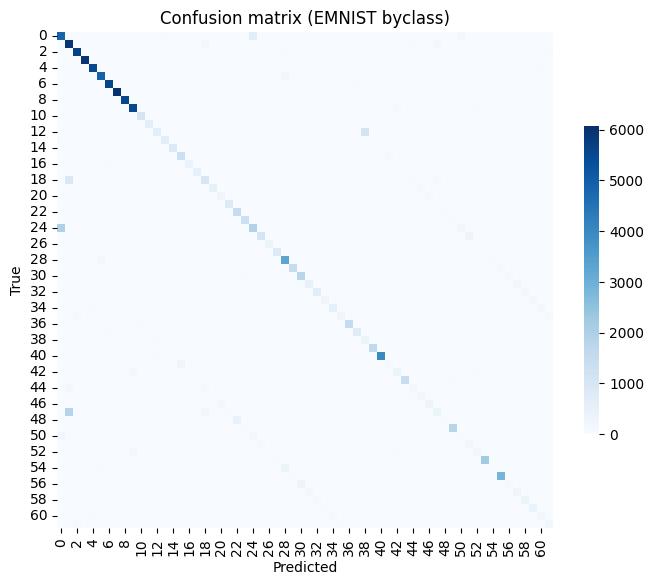


Classification report (first 20 classes):
    precision    recall  f1-score  support
0    0.679066  0.840429  0.751180   5778.0
1    0.670206  0.937441  0.781612   6330.0
2    0.962456  0.969671  0.966050   5869.0
3    0.991781  0.990618  0.991199   5969.0
4    0.974929  0.975796  0.975362   5619.0
5    0.953298  0.943931  0.948591   5190.0
6    0.968718  0.982472  0.975546   5705.0
7    0.988925  0.989086  0.989006   6139.0
8    0.988744  0.982425  0.985574   5633.0
9    0.934362  0.968871  0.951304   5686.0
10   0.954334  0.964218  0.959251   1062.0
11   0.928251  0.958333  0.943052    648.0
12   0.843794  0.347901  0.492671   1739.0
13   0.921488  0.858793  0.889037    779.0
14   0.964158  0.948296  0.956161    851.0
15   0.796933  0.902083  0.846254   1440.0
16   0.934307  0.859060  0.895105    447.0
17   0.917582  0.961612  0.939082    521.0
18   0.649157  0.488770  0.557660   2048.0
19   0.931373  0.758786  0.836268    626.0


In [ ]:
# This may take a few minutes (runs predictions over the test set)
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# gather preds and truths
y_true = []
y_pred = []
for imgs, labels in ds_test_fixed:
    preds = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

# plot matrix (smaller size to fit)
plt.figure(figsize=(8,8))
sns.heatmap(cm, cmap="Blues", square=True, cbar_kws={'shrink':0.5})
plt.title("Confusion matrix (EMNIST byclass)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# classification report (first 20 classes for readability)
report = classification_report(y_true, y_pred, output_dict=True)
import pandas as pd
df = pd.DataFrame(report).T
print("\nClassification report (first 20 classes):")
print(df.iloc[:20][['precision','recall','f1-score','support']])

Top worst classes (by recall): [54, 48, 50, 47, 41, 56]


/tmp/ipython-input-1548947909.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_rows.append(int(labels.numpy()))



Class 54 - 437 examples in test set. Showing up to 5 misclassified:


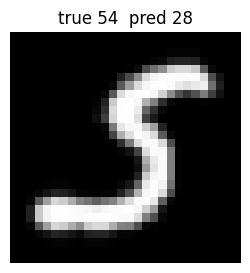

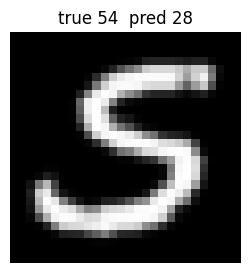

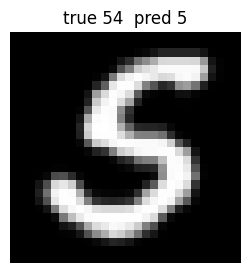

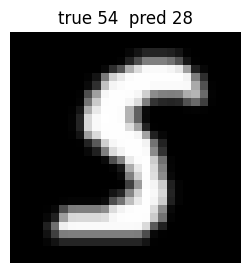

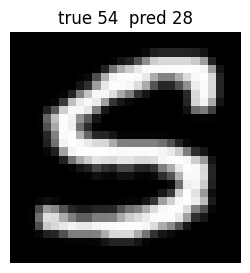


Class 48 - 464 examples in test set. Showing up to 5 misclassified:


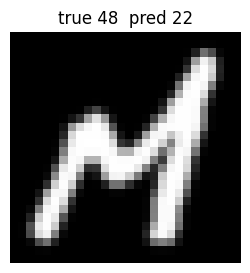

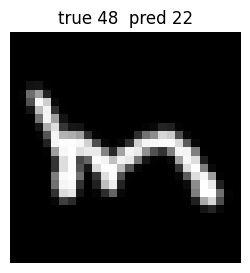

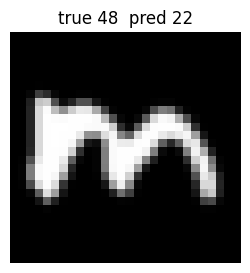

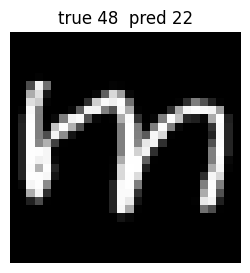

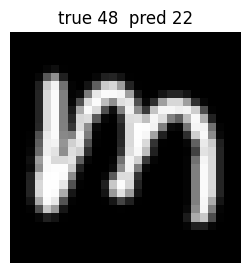


Class 50 - 466 examples in test set. Showing up to 5 misclassified:


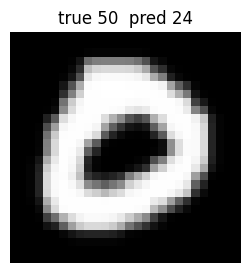

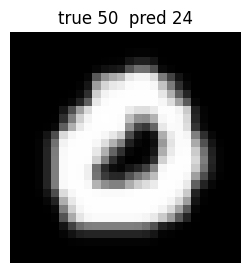

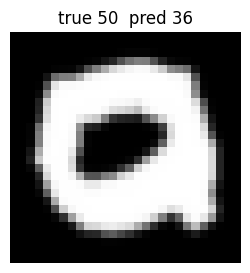

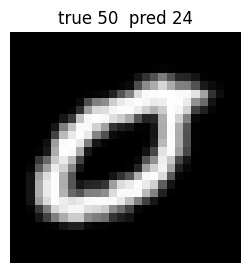

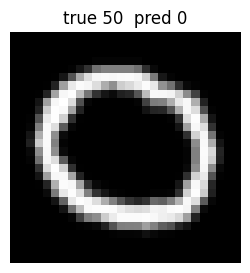


Class 47 - 2535 examples in test set. Showing up to 5 misclassified:


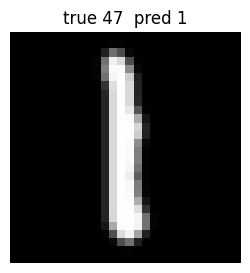

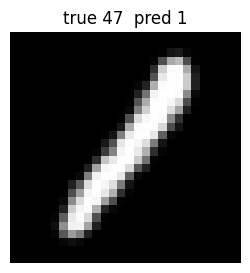

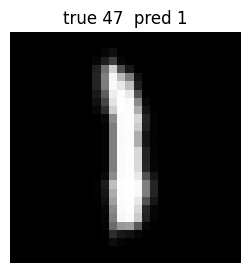

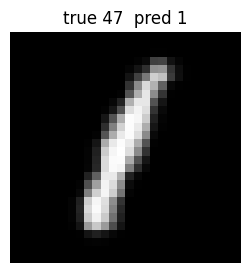

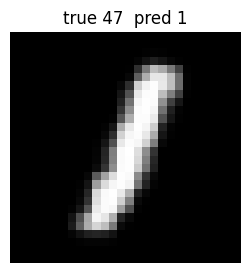


Class 41 - 400 examples in test set. Showing up to 5 misclassified:


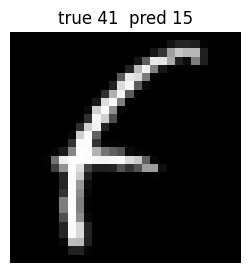

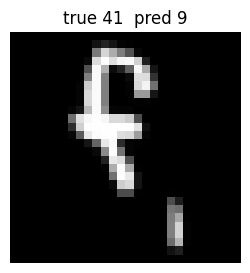

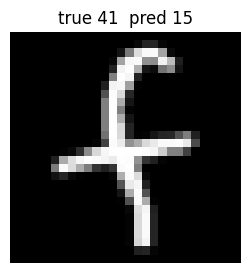

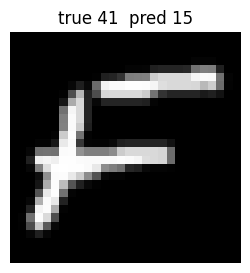

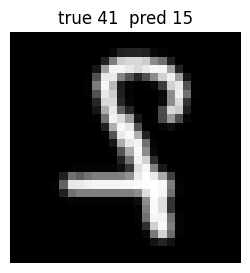


Class 56 - 482 examples in test set. Showing up to 5 misclassified:


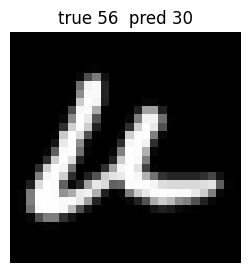

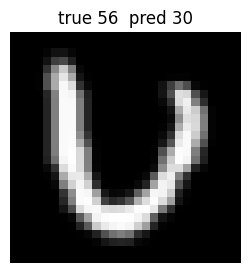

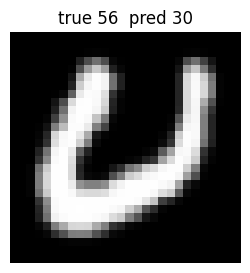

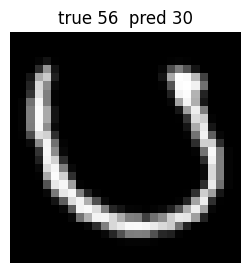

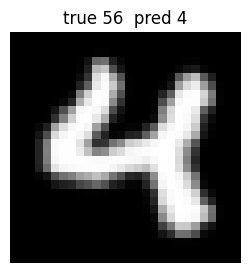

In [ ]:
# Find worst classes by recall
recall_per_class = df.loc[[str(i) if str(i) in df.index else i for i in range(len(cm))], 'recall']
# If indexes are strings in df, handle both: convert index names
try:
    recalls = [float(df.loc[i,'recall']) for i in range(cm.shape[0])]
except:
    recalls = [float(df.loc[str(i),'recall']) for i in range(cm.shape[0])]

recalls = np.array(recalls)
worst_idx = np.argsort(recalls)[:6]  # top 6 lowest recall
print("Top worst classes (by recall):", worst_idx.tolist())

# collect some sample images for display
X_samples = []   # will store some fixed-orientation images
labels_rows = []
for imgs, labels in ds_test_fixed.unbatch().batch(1).take(2000):  # take up to 2000 samples (adjust if needed)
    X_samples.append(imgs.numpy())
    labels_rows.append(int(labels.numpy()))
X_samples = np.vstack(X_samples)  # shape (N,28,28,1)

# show up to 5 examples for each worst class
import matplotlib.pyplot as plt
for cls in worst_idx:
    idxs = np.where(y_true==cls)[0]
    if len(idxs)==0:
        continue
    print(f"\nClass {cls} - {len(idxs)} examples in test set. Showing up to 5 misclassified:")
    mis = [i for i in idxs if y_pred[i] != cls]
    show_idxs = mis[:5] if len(mis)>0 else idxs[:5]
    for i in show_idxs:
        # we need the sample image corresponding to index i — we built X_samples from the dataset order,
        # so we can use that if sizes matched. If not aligned, we instead predict directly and show a batch sample.
        plt.figure(figsize=(3,3))
        # find corresponding image: you can use ds_test_fixed.unbatch().skip(i).take(1) to fetch exactly, but slower.
        # We'll display by reloading single sample from the dataset at index i:
        sample = ds_test_fixed.unbatch().skip(int(i)).take(1)
        for img_batch, lbl_batch in sample:
            plt.imshow(np.squeeze(img_batch.numpy()), cmap='gray')
            plt.title(f"true {lbl_batch.numpy()}  pred {y_pred[i]}")
            plt.axis('off')
            plt.show()
            break

In [ ]:
import os, math, random, pickle
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Where to save checkpoints / final model
SAVE_DIR = "/content/drive/MyDrive/EMNIST_Project"
os.makedirs(SAVE_DIR, exist_ok=True)

# problem classes you found
PROBLEM_CLASSES = [54, 48, 50, 47, 41, 56]

# training hyperparams - tune if you want
BATCH = 128
EPOCHS_FINE = 4        # small number to start
AUG_PER_SAMPLE = 6     # how many augmented variants to create per minority sample
LR_FINE = 1e-5         # small lr for fine-tuning

print("Will oversample classes:", PROBLEM_CLASSES)
print("Save dir:", SAVE_DIR)

Will oversample classes: [54, 48, 50, 47, 41, 56]
Save dir: /content/drive/MyDrive/EMNIST_Project


In [ ]:
import tensorflow as tf

def augment_map(img, lbl):
    # Random horizontal flip
    img = tf.image.random_flip_left_right(img)

    # Random rotation (using Keras preprocessing)
    angle = tf.random.uniform([], -20, 20)  # degrees
    img = tf.keras.preprocessing.image.random_rotation(img.numpy() * 255., angle, row_axis=0, col_axis=1, channel_axis=2)
    img = tf.convert_to_tensor(img / 255., dtype=tf.float32)

    # Random zoom & crop
    zoom_factor = tf.random.uniform([], 0.9, 1.0)
    crop_size = tf.cast(28 * zoom_factor, tf.int32)
    img = tf.image.resize_with_crop_or_pad(img, 28, 28)
    img = tf.image.random_crop(img, size=[crop_size, crop_size, 1])
    img = tf.image.resize(img, [28, 28])

    # Brightness & contrast tweaks
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)

    # Small Gaussian noise
    noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=0.02)
    img = tf.clip_by_value(img + noise, 0.0, 1.0)

    return img, lbl

print("✅ Augmentation function ready (no addons needed).")

✅ Augmentation function ready (no addons needed).


In [ ]:
# use same fix as before (must match training)
def fix_emnist_numpy(img, label):
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)
    img = np.rot90(img)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

# augmentation (TensorFlow ops)
@tf.function
def aug_tf(img, label):
    # img: float32 [28,28,1], values in [0,1]
    img = tf.image.random_flip_left_right(img)  # small chance, okay because we mirrored earlier
    # small random rotation - use tf.contrib is not available, use rotate via tf.keras
    angle = tf.random.uniform([], -0.35, 0.35)  # radians ~ +/-20deg
    img = tfa.image.rotate(img, angle, fill_mode='constant') if 'tfa' in globals() else tf.keras.preprocessing.image.random_rotation(img*255., 20, row_axis=0, col_axis=1, channel_axis=2)/255.
    # random translation
    img = tf.image.random_shift(img, 0.08, 0.08) if hasattr(tf.image, 'random_shift') else img
    # slight random zoom via resize
    sz = tf.random.uniform([], 25, 28, dtype=tf.int32)
    img2 = tf.image.resize(img, [sz, sz])
    img2 = tf.image.resize_with_crop_or_pad(img2, 28, 28)
    # small gaussian noise
    img2 = img2 + tf.random.normal(tf.shape(img2), mean=0.0, stddev=0.02)
    img2 = tf.clip_by_value(img2, 0.0, 1.0)
    return img2, label

In [ ]:
import tensorflow_datasets as tfds

# load train split and apply fix
ds_train_raw = tfds.load("emnist/byclass", split="train", as_supervised=True)
ds_train_fixed = ds_train_raw.map(tf_fix, num_parallel_calls=tf.data.AUTOTUNE)

# create minority subset (filter by label in PROBLEM_CLASSES)
def is_problem(img, lbl):
    return tf.reduce_any(tf.equal(lbl, PROBLEM_CLASSES))

ds_minority = ds_train_fixed.filter(lambda x,y: tf.reduce_any(tf.equal(y, PROBLEM_CLASSES)))
print("Minority dataset prepared (filtered).")

Minority dataset prepared (filtered).


In [ ]:
# If tensorflow_addons not installed, avoid rotate op that uses tfa; use a simple augmentation function
try:
    import tensorflow_addons as tfa
    has_tfa = True
except Exception:
    has_tfa = False
    print("Note: tensorflow_addons not available — using simpler augmentation.")

def augment_map(img, lbl):
    # apply several random transforms; if tfa present, use rotate
    img2 = img
    # random flip
    img2 = tf.image.random_flip_left_right(img2)
    # random small rotation if tfa else small random cropping/resizing
    if has_tfa:
        angle = tf.random.uniform([], -0.35, 0.35)
        img2 = tfa.image.rotate(img2, angle, fill_mode='constant')
    else:
        # random crop & resize
        crop_pct = tf.random.uniform([], 0.92, 1.0)
        h = tf.cast(28*crop_pct, tf.int32)
        w = tf.cast(28*crop_pct, tf.int32)
        img2 = tf.image.resize_with_crop_or_pad(img2, 30, 30)
        img2 = tf.image.random_crop(img2, size=[h,w,1])
        img2 = tf.image.resize(img2, [28,28])
    # random brightness/contrast and small noise
    img2 = tf.image.random_brightness(img2, 0.05)
    img2 = tf.image.random_contrast(img2, 0.9, 1.1)
    img2 = img2 + tf.random.normal(tf.shape(img2), stddev=0.02)
    img2 = tf.clip_by_value(img2, 0.0, 1.0)
    return img2, lbl

# repeat each minority sample AUG_PER_SAMPLE times via flat_map
ds_minority_aug = ds_minority.flat_map(lambda img, lbl: tf.data.Dataset.from_tensors((img,lbl)).concatenate(
    tf.data.Dataset.from_tensors((img,lbl)).repeat(AUG_PER_SAMPLE)
))
# map augmentation
ds_minority_aug = ds_minority_aug.map(augment_map, num_parallel_calls=tf.data.AUTOTUNE)

# batch and prefetch
ds_minority_aug = ds_minority_aug.shuffle(2000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
print("Augmented minority dataset prepared. Each sample approx repeated x", AUG_PER_SAMPLE)

Note: tensorflow_addons not available — using simpler augmentation.
Augmented minority dataset prepared. Each sample approx repeated x 6


In [ ]:
# original full train (shuffle, batch)
ds_train_full = ds_train_fixed.shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Combine: concat original train with augmented minority dataset (you can change order)
ds_combined = ds_train_full.concatenate(ds_minority_aug)
ds_combined = ds_combined.shuffle(20000).prefetch(tf.data.AUTOTUNE)

print("Combined dataset ready. Example iteration check:")
for x,y in ds_combined.take(1):
    print("batch shapes:", x.shape, y.shape)
    break

Combined dataset ready. Example iteration check:
batch shapes: (128, 28, 28, 1) (128,)


In [ ]:
# require `model` present (your loaded model)
if 'model' not in globals():
    raise RuntimeError("Model not found in notebook. Load model first.")

opt = keras.optimizers.Adam(learning_rate=LR_FINE)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ckpt_path = os.path.join(SAVE_DIR, "ckpt_emnist_finetune_epoch{epoch:02d}_val{val_accuracy:.4f}.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

# create a small validation set from test or from train's holdout — here we use test for quickness:
ds_val = tfds.load("emnist/byclass", split="test[:5%]", as_supervised=True).map(tf_fix).batch(BATCH).prefetch(tf.data.AUTOTUNE)

print("Starting fine-tune epochs:", EPOCHS_FINE)
history = model.fit(ds_combined, epochs=EPOCHS_FINE, validation_data=ds_val, callbacks=callbacks, verbose=1)
print("Fine-tune done.")

Starting fine-tune epochs: 4
Epoch 1/4
   7029/Unknown 2617s 290ms/step - accuracy: 0.7609 - loss: 0.5926

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7029/7029 ━━━━━━━━━━━━━━━━━━━━ 2624s 291ms/step - accuracy: 0.7609 - loss: 0.5926 - val_accuracy: 0.8343 - val_loss: 0.3897
Epoch 2/4
7029/7029 ━━━━━━━━━━━━━━━━━━━━ 2645s 294ms/step - accuracy: 0.8369 - loss: 0.4392 - val_accuracy: 0.8437 - val_loss: 0.3746
Epoch 3/4
7029/7029 ━━━━━━━━━━━━━━━━━━━━ 2614s 292ms/step - accuracy: 0.8556 - loss: 0.3953 - val_accuracy: 0.8449 - val_loss: 0.3704
Epoch 4/4
7029/7029 ━━━━━━━━━━━━━━━━━━━━ 2678s 293ms/step - accuracy: 0.8673 - loss: 0.3678 - val_accuracy: 0.8569 - val_loss: 0.3550
Fine-tune done.


In [ ]:
final_path = os.path.join(SAVE_DIR, "final_emnist_finetuned_augmented.keras")
model.save(final_path)
print("✅ Final fine-tuned model saved to:", final_path)

# save history
hist_path = os.path.join(SAVE_DIR, "history_finetune_augmented.pkl")
with open(hist_path, "wb") as f:
    pickle.dump(history.history, f)
print("✅ History saved to:", hist_path)

✅ Final fine-tuned model saved to: /content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_augmented.keras
✅ History saved to: /content/drive/MyDrive/EMNIST_Project/history_finetune_augmented.pkl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

# load model
model_path = "/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_augmented.keras"
model = keras.models.load_model(model_path)
print("✅ Model loaded successfully!")

# fixed orientation preprocess
def fix_emnist_numpy(img, label):
    img = np.squeeze(img).astype(np.uint8)
    img = np.fliplr(img)
    img = np.rot90(img)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img, label

def tf_fix(img, label):
    img_fixed, lbl = tf.numpy_function(fix_emnist_numpy, [img, label], [tf.float32, tf.int64])
    img_fixed.set_shape((28,28,1))
    lbl.set_shape(())
    return img_fixed, lbl

BATCH = 128
ds_test_fixed = tfds.load("emnist/byclass", split="test", as_supervised=True)
ds_test_fixed = ds_test_fixed.map(tf_fix).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# evaluate
test_loss, test_acc = model.evaluate(ds_test_fixed, verbose=1)
print(f"\n✅ Final test accuracy: {test_acc*100:.2f}% | loss: {test_loss:.4f}")

✅ Model loaded successfully!


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.61OXAS_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.61OXAS_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
909/909 ━━━━━━━━━━━━━━━━━━━━ 91s 100ms/step - accuracy: 0.8560 - loss: 0.3774

✅ Final test accuracy: 85.65% | loss: 0.3773


In [4]:
import os, glob
SAVE_DIR = "/content/drive/MyDrive/EMNIST_Project"
files = sorted(glob.glob(os.path.join(SAVE_DIR, "*.keras")))
for f in files:
    print(os.path.basename(f), "-", os.path.getsize(f)//1024, "KB")
print("\nAll files in folder:")
print(sorted(os.listdir(SAVE_DIR)))

ckpt_emnist_finetune_epoch01_val0.8343.keras - 4806 KB
ckpt_emnist_finetune_epoch01_val0.8542.keras - 4806 KB
ckpt_emnist_finetune_epoch01_val0.8700.keras - 4806 KB
ckpt_emnist_finetune_epoch02_val0.8437.keras - 4806 KB
ckpt_emnist_finetune_epoch02_val0.8558.keras - 4806 KB
ckpt_emnist_finetune_epoch03_val0.8449.keras - 4806 KB
ckpt_emnist_finetune_epoch03_val0.8571.keras - 4806 KB
ckpt_emnist_finetune_epoch04_val0.8569.keras - 4806 KB
ckpt_emnist_finetune_epoch04_val0.8587.keras - 4806 KB
final_emnist.keras - 4806 KB
final_emnist_finetuned.keras - 4806 KB
final_emnist_finetuned_augmented.keras - 4806 KB
final_emnist_finetuned_v2.keras - 4806 KB
final_emnist_fixed.keras - 1637 KB

All files in folder:
['ckpt_emnist_finetune_epoch01_val0.8343.keras', 'ckpt_emnist_finetune_epoch01_val0.8542.keras', 'ckpt_emnist_finetune_epoch01_val0.8700.keras', 'ckpt_emnist_finetune_epoch02_val0.8437.keras', 'ckpt_emnist_finetune_epoch02_val0.8558.keras', 'ckpt_emnist_finetune_epoch03_val0.8449.keras', 

In [5]:
from tensorflow import keras
import os

# change filename if you intended a different file
model_file = "/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_augmented.keras"
print("Loading model from:", model_file)
model = keras.models.load_model(model_file)
print("✅ Model loaded. Summary:")
model.summary()   # check architecture and parameter counts

Loading model from: /content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_augmented.keras
✅ Model loaded. Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,116 (4.63 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 808,446 (3.08 MB)

In [6]:
summary_data = {
    "Model": "final_emnist_finetuned_augmented",
    "Accuracy (%)": round(test_acc * 100, 2),
    "Loss": round(test_loss, 4),
    "Params": model.count_params()
}

import pandas as pd
import json

# save results
df = pd.DataFrame([summary_data])
df.to_csv("/content/drive/MyDrive/EMNIST_Project/final_results_summary.csv", index=False)
with open("/content/drive/MyDrive/EMNIST_Project/final_results_summary.json", "w") as f:
    json.dump(summary_data, f, indent=4)

print("✅ Final results saved to Drive")
print(df)

✅ Final results saved to Drive
                              Model  Accuracy (%)    Loss  Params
0  final_emnist_finetuned_augmented         85.65  0.3773  404670


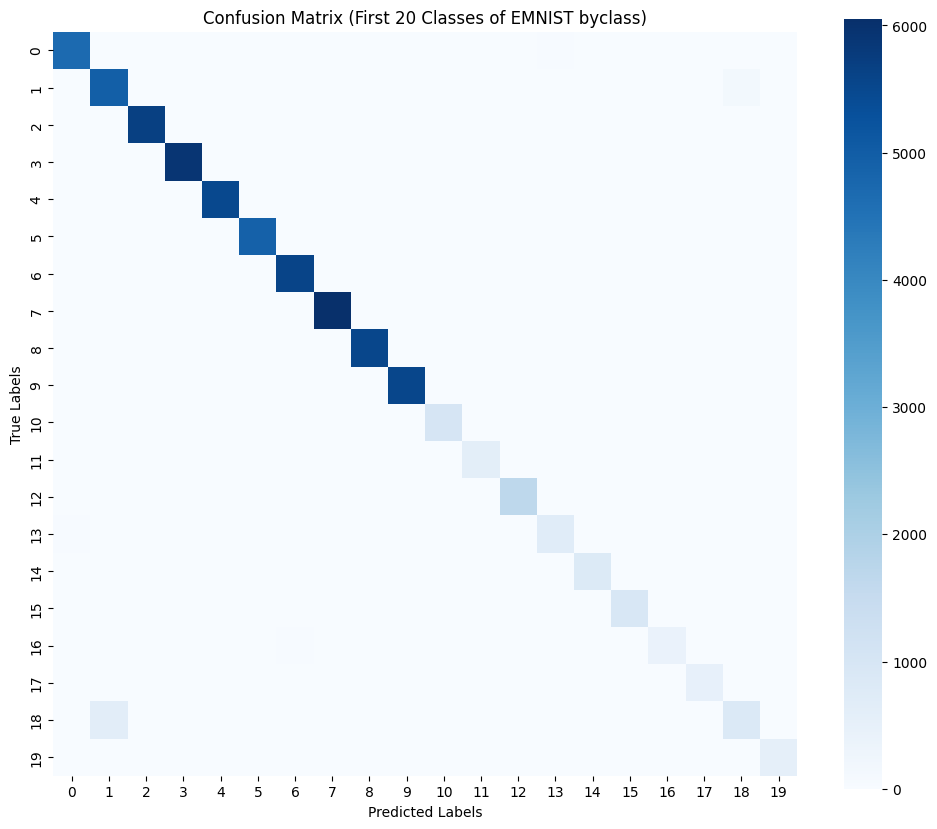


📊 Classification Report (first 20 classes):

              precision    recall  f1-score   support

           0      0.692     0.814     0.748      5778
           1      0.713     0.784     0.747      6330
           2      0.965     0.967     0.966      5869
           3      0.995     0.993     0.994      5969
           4      0.975     0.980     0.978      5619
           5      0.956     0.947     0.951      5190
           6      0.978     0.980     0.979      5705
           7      0.991     0.986     0.989      6139
           8      0.986     0.985     0.986      5633
           9      0.932     0.977     0.954      5686
          10      0.955     0.976     0.965      1062
          11      0.942     0.958     0.950       648
          12      0.779     0.959     0.860      1739
          13      0.900     0.890     0.895       779
          14      0.962     0.964     0.963       851
          15      0.883     0.666     0.759      1440
          16      0.933     0.908  

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_true, y_pred = [], []
for imgs, labels in ds_test_fixed:
    preds = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm[:20, :20], cmap='Blues', square=True, cbar=True)
plt.title("Confusion Matrix (First 20 Classes of EMNIST byclass)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, digits=3, zero_division=0, output_dict=False)
print("\n📊 Classification Report (first 20 classes):\n")
print(report)

In [ ]:
# ✅ Install required libraries
!pip install -q opencv-python-headless scipy tensorflow-datasets gradio

# ✅ Imports
import numpy as np
import cv2
from scipy import ndimage
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import gradio as gr
from tensorflow import keras
import string

# # ✅ Load your fine-tuned model (uncomment & set path)
# model_path = "/content/drive/MyDrive/EMNIST_Project/final_emnist_finetuned_augmented.keras"
# model = keras.models.load_model(model_path)
# print("✅ Model loaded successfully!")

# ✅ Fixed EMNIST byclass label map
label_map = (
    list(string.digits) +              # 0–9
    list(string.ascii_uppercase) +     # 10–35
    list(string.ascii_lowercase)       # 36–61
)
print("✅ Fixed label map loaded — Total:", len(label_map))
print("Example labels:", label_map[:20])

def preprocess_for_model_pil_cv(pil_img, debug_show=False):
    """
    Improved preprocessing:
     - grayscale, blur, invert, threshold, close
     - crop to combined contours
     - deskew using PCA (stable)
     - resize so max side = 20 and paste centered on 28x28
     - center-of-mass alignment
     - choose best rotation candidate (no left/right mirror flips)
    Returns: (1,28,28,1) float32 normalized, debug canvas (uint8 28x28)
    """
    # 1. Grayscale array
    img = pil_img.convert("L")
    arr = np.array(img)

    # 2. Blur to remove noise
    arr_blur = cv2.GaussianBlur(arr, (5,5), 0)

    # 3. Invert (foreground white)
    arr_inv = 255 - arr_blur

    # 4. Threshold: Otsu + fallback
    _, th_otsu = cv2.threshold(arr_inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if th_otsu.sum() < 50:
        th = cv2.adaptiveThreshold(arr_inv, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 31, 10)
    else:
        th = th_otsu

    # 5. Morphological close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 6. Find contours and bounding box
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        canvas = np.zeros((28,28), dtype=np.uint8)
        return (canvas/255.0).astype(np.float32)[None,:,:,None], canvas

    all_pts = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_pts)

    # 7. Add padding and crop from inverted original (arr_inv)
    pad = int(max(w, h) * 0.30)
    x0 = max(0, x - pad)
    y0 = max(0, y - pad)
    x1 = min(arr.shape[1]-1, x + w + pad)
    y1 = min(arr.shape[0]-1, y + h + pad)
    cropped = arr_inv[y0:y1+1, x0:x1+1]

    # 8. Enforce minimum crop size
    ch, cw = cropped.shape
    if min(ch, cw) < 12:
        extra = (12 - min(ch,cw))//2 + 1
        cropped = cv2.copyMakeBorder(cropped, extra, extra, extra, extra,
                                     cv2.BORDER_CONSTANT, value=0)

    # ---------- Deskew using PCA (principal component) ----------
    # Use foreground points for PCA so orientation is stable for letters with loops
    _, bin_crop = cv2.threshold(cropped, 1, 255, cv2.THRESH_BINARY)
    pts = cv2.findNonZero(bin_crop)  # Nx1x2 or None
    if pts is not None and len(pts) >= 5:
        pts = pts.reshape(-1, 2).astype(np.float32)  # (x,y)
        # center
        mean = pts.mean(axis=0)
        centered = pts - mean
        cov = np.cov(centered, rowvar=False)
        eigvals, eigvecs = np.linalg.eigh(cov)
        principal_idx = np.argmax(eigvals)
        principal = eigvecs[:, principal_idx]  # vector (x_comp, y_comp)
        angle_rad = np.arctan2(principal[1], principal[0])
        angle_deg = np.degrees(angle_rad)
        # rotate so principal axis becomes vertical:
        rot_angle = 90.0 - angle_deg
        (h_c, w_c) = cropped.shape
        center = (w_c // 2, h_c // 2)
        M = cv2.getRotationMatrix2D(center, -rot_angle, 1.0)
        cropped = cv2.warpAffine(cropped, M, (w_c, h_c),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    # else: fallback -> keep cropped

    # optional contrast equalization
    try:
        cropped = cv2.equalizeHist(cropped)
    except Exception:
        pass

    # 9. Resize so the largest side is 20 px
    h2, w2 = cropped.shape
    scale = 20.0 / max(h2, w2)
    new_w, new_h = max(1, int(round(w2 * scale))), max(1, int(round(h2 * scale)))
    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 10. Paste centered on 28x28 canvas
    canvas = np.zeros((28,28), dtype=np.uint8)
    left, top = (28 - new_w)//2, (28 - new_h)//2
    canvas[top:top+new_h, left:left+new_w] = resized

    # 11. Center-of-mass alignment
    cy, cx = ndimage.center_of_mass(canvas)
    if np.isnan(cy) or np.isnan(cx):
        cy, cx = 14, 14
    shift_y, shift_x = int(round(14 - cy)), int(round(14 - cx))
    canvas = ndimage.shift(canvas, shift=(shift_y, shift_x), mode='constant', cval=0.0)

    # 12. Candidate orientations (rotations only — no left/right mirror flips)
    def bbox_hw(a):
        ys, xs = np.where(a > 0)
        if len(ys) == 0:
            return 0.0, 0, 0, 0.0
        y0, y1 = ys.min(), ys.max()
        x0, x1 = xs.min(), xs.max()
        h = y1 - y0 + 1
        w = x1 - x0 + 1
        cy = (y0 + y1) / 2.0
        cx = (x0 + x1) / 2.0
        dist_center = np.sqrt((cy - 13.5)**2 + (cx - 13.5)**2)
        return (h / (w + 1e-8)), h, w, dist_center

    # Try four rotations only (avoid flips that mirror shapes)
    candidates = [
        canvas.copy(),
        np.rot90(canvas, k=1),
        np.rot90(canvas, k=2),
        np.rot90(canvas, k=3),
    ]

    best_idx = 0
    best_score = -1e9
    for i, c in enumerate(candidates):
        aspect, hh, ww, dist = bbox_hw(c)
        bbox_area = hh * ww
        area_factor = 1.0 + min(bbox_area / 300.0, 2.0)
        center_penalty = 1.0 - (dist / 20.0)
        combined = aspect * area_factor * max(center_penalty, 0.2)
        if combined > best_score:
            best_score = combined
            best_idx = i

    canvas = candidates[best_idx]

    # 13. (Optional) If your model was trained with a specific EMNIST transform, apply here.
    # For now we DO NOT apply unconditional fliplr/rot90 to avoid reintroducing wrong orientation.

    # 14. Normalize & shape
    final = (canvas / 255.0).astype(np.float32)
    final = np.expand_dims(final, (0, -1))  # (1,28,28,1)

    debug_img = canvas.astype(np.uint8)
    if debug_show:
        plt.figure(figsize=(3,3))
        plt.imshow(debug_img, cmap='gray')
        plt.title("Processed 28x28 (chosen orientation)")
        plt.axis('off')
        plt.show()

    return final, debug_img

# ✅ Define prediction + debugging function (same as yours)
def predict_and_debug(pil_img, topk=5):
    x, debug_img = preprocess_for_model_pil_cv(pil_img, debug_show=False)
    preds = model.predict(x)[0]
    top_idx = preds.argsort()[::-1][:topk]

    lines = []
    for idx in top_idx:
        conf = float(preds[idx])
        char = label_map[idx] if idx < len(label_map) else f"class {idx}"
        lines.append(f"'{char}' — {conf*100:.1f}% confidence")
    txt = "\n".join(lines)

    dbg_pil = Image.fromarray(debug_img).convert("L")
    return txt, dbg_pil

# ✅ Gradio interface
def gr_fn(pil_img):
    return predict_and_debug(pil_img, topk=5)

if __name__ == "__main__":
    # Vercel exposes PORT via env var; default fallback 7860 for local tests
    port = int(os.environ.get("PORT", 7860))
    # Launch in non-blocking mode that serves on 0.0.0.0
    iface.launch(server_name="0.0.0.0", server_port=port, share=False)

iface = gr.Interface(
    fn=gr_fn,
    inputs=gr.Image(type="pil", label="Upload or draw a character"),
    outputs=[
        gr.Textbox(label="Top predictions (char, class, conf)"),
        gr.Image(type="pil", label="Processed 28x28 (what model sees)")
    ],
    title="🧠 EMNIST Handwritten Character Recognition",
    description="Upload a handwritten character (digit or letter) — model predicts its class using your fine-tuned EMNIST model."
)

iface.launch(share=True)

✅ Fixed label map loaded — Total: 62
Example labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cb5b2ba9ec3a5c06ea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
iface.launch(server_name="0.0.0.0", server_port=int(os.getenv("PORT", 7860)))